## Hengwei Zhang z5490612

# Part 1. Topic Classification
## Q1.
- (i) Change to deleting symbols other than letters, numbers, Spaces, apostrophes and hyphens.
- (ii) The result of a single division is too sensitive to random segmentation, with a large evaluation variance and unstable results. Change to K-fold cross-validation.

## Q2. 
According to the result in the picture below. Compared 8 preprocessing pipelines (do_stem: stem or not; rm_stop: remove stopwords or not; ngram_range: (1,1) vs. (1,2)) using 5-fold CV on MultinomialNB.
- Best parameters:
    - No stemming (do_stem=False)
    - Remove stopwords (rm_stop=True)
    - Unigrams only (ngram_range=(1,1))
- Best CV accuracy: 0.7973 (~79.7%)

Under this pipeline, MNB slightly outperforms BNB. Thus, for the rest of Part 1 we’ll use:
1. re.sub(r"[^A-Za-z0-9\s'\-]", '', text) to strip unwanted symbols
2. text.lower()
3. NLTK tokenization + stopword removal
4. No stemming
5. CountVectorizer(ngram_range=(1,1)) (unigrams)
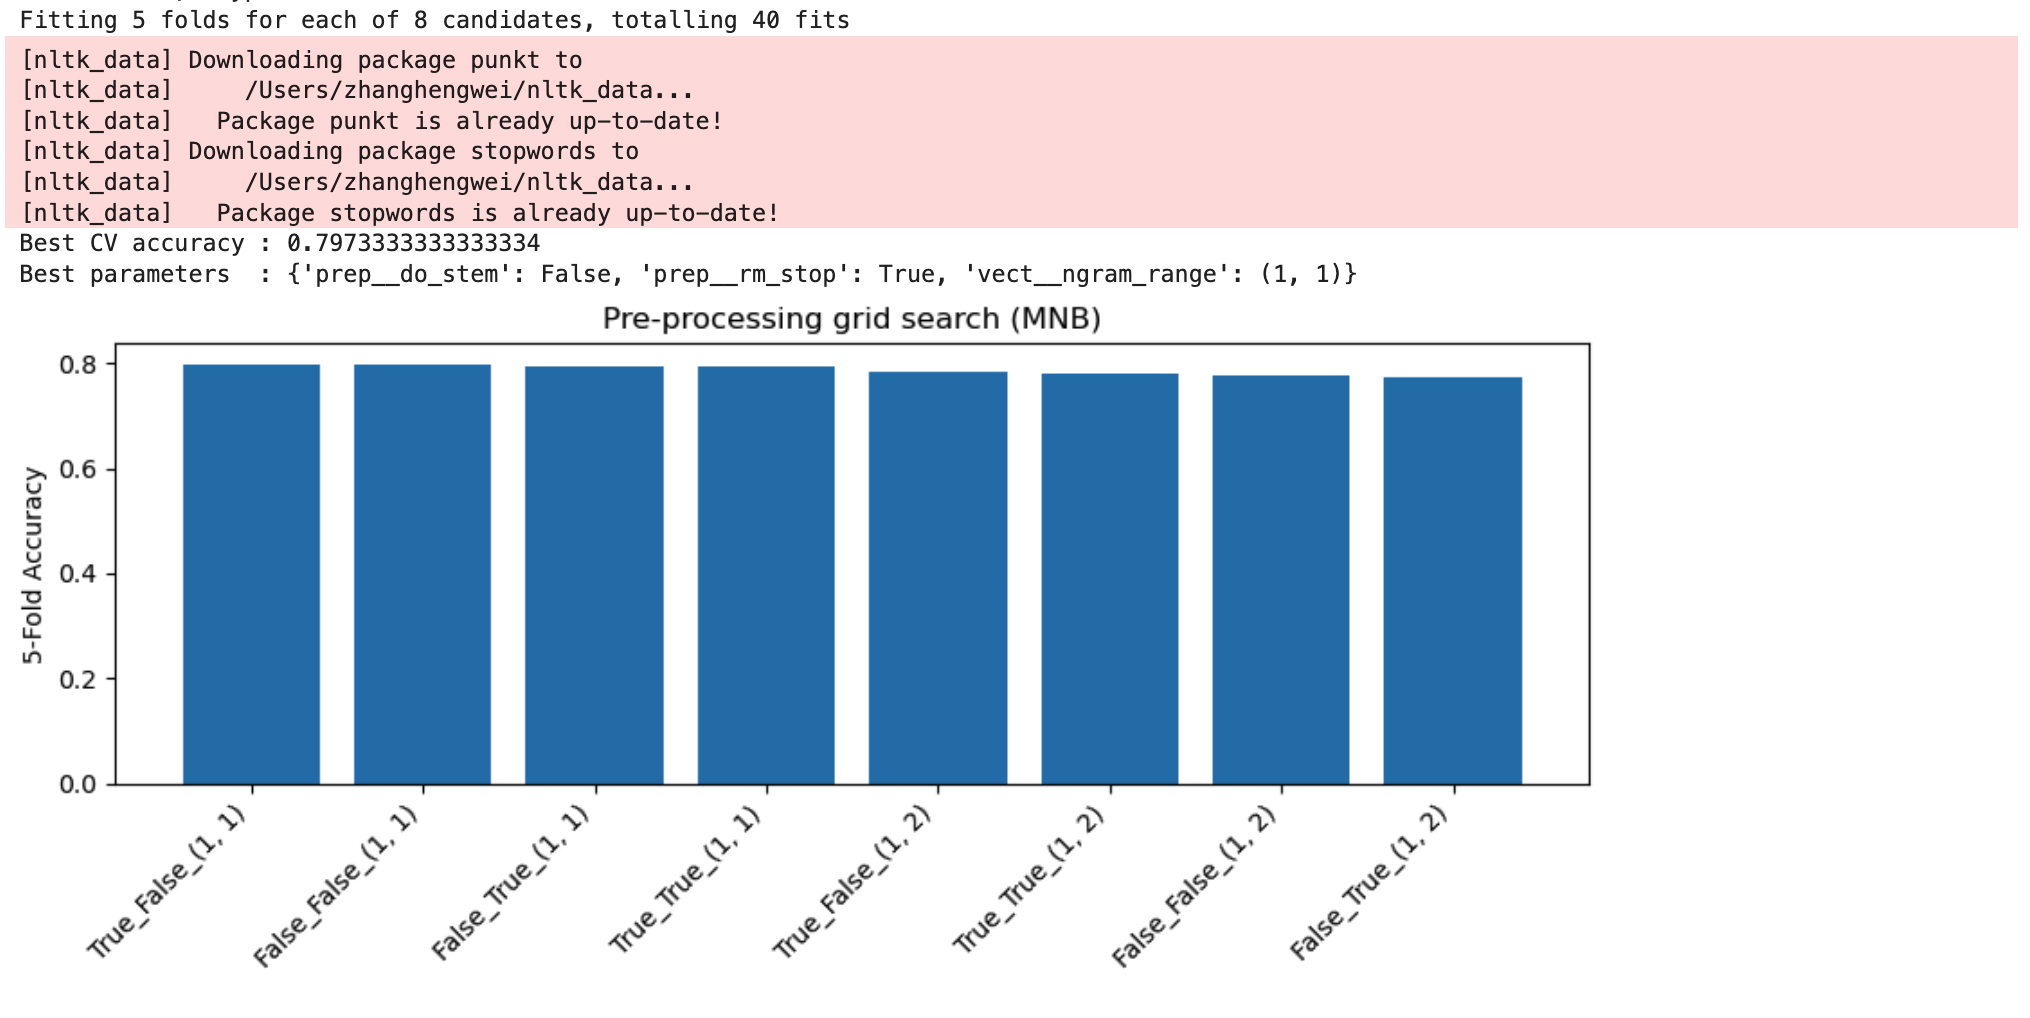

__Part1 Q2 Code__

,artist_name,track_name,release_date,genre,lyrics,topic,full_text
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark,loving the not real lake 2016 rock awake know ...
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle,incubus into the summer 2019 rock shouldn summ...
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness,reignwolf hardcore 2016 blues lose deep catch ...
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness,tedeschi trucks band anyhow 2016 blues run bit...
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark,lukas nelson and promise of the real if i star...
5,tia ray,just my luck,2018,jazz,yeah happen real drink drink turn shots lose c...,emotion,tia ray just my luck 2018 jazz yeah happen rea...
6,rebelution,trap door,2018,reggae,long long road occur look shortcut wanna caus...,dark,rebelution trap door 2018 reggae long long ro...
7,thank you scientist,the amateur arsonist's handbook,2016,jazz,quick think good true worst best things foreve...,dark,thank you scientist the amateur arsonist's han...
8,zayde wølf,gladiator,2018,rock,start climb face army vipers lions reach cause...,dark,zayde wølf gladiator 2018 rock start climb fac...
9,eli young band,never land,2017,country,word yeah wreck roll lips high good get bottle...,sadness,eli young band never land 2017 country word ye...


Shape: (1500, 7)
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zhanghengwei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhanghengwei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Best CV accuracy : 0.7973333333333334
Best parameters  : {'prep__do_stem': False, 'prep__rm_stop': True, 'vect__ngram_range': (1, 1)}


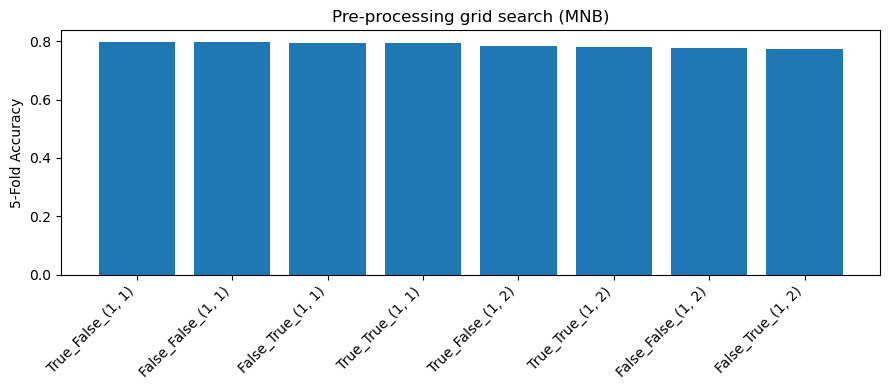

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split

# read data
df = pd.read_csv("/Users/zhanghengwei/Documents/9727project/assignment1/dataset.tsv", sep="\t")

#filter topics
target_topics = ["dark", "emotion", "lifestyle", "personal", "sadness"]
# df = df[df["topic"].isin(target_topics)].reset_index(drop=True)

text_cols = ["artist_name", "track_name", "release_date", "genre", "lyrics"]
df["full_text"] = df[text_cols].astype(str).agg(" ".join, axis=1)
# remove other column
# df = df[['full_text', 'topic']]

display(df.head(10))

print("Shape:", df.shape)
print(df["topic"].value_counts())

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, make_scorer, f1_score
# ----------------------------------------------------------------------
# Stratified 5-fold object
# ----------------------------------------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk, re
nltk.download("punkt")
nltk.download("stopwords")

ps = PorterStemmer()
stop_words = set(stopwords.words("english"))

def basic_preprocess(text: str,
                     to_lower: bool = True,
                     rm_stop: bool = True,
                     do_stem: bool = True,
                     regex: str = r"[A-Za-z][A-Za-z\-\']{1,}") -> str:
    """Return cleaned text string."""
    if to_lower:
        text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if re.fullmatch(regex, t)]
    if rm_stop:
        tokens = [t for t in tokens if t not in stop_words]
    if do_stem:
        tokens = [ps.stem(t) for t in tokens]
    return " ".join(tokens)

class TextPreprocessor(BaseEstimator, TransformerMixin):
    """Sk-learn transformer wrapping basic_preprocess with switches."""
    def __init__(self, to_lower=True, rm_stop=True, do_stem=True):
        self.to_lower, self.rm_stop, self.do_stem = to_lower, rm_stop, do_stem
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(lambda x: basic_preprocess(
            x, self.to_lower, self.rm_stop, self.do_stem))

# ----------------------------------------------------------------------
# Build pipeline
# ----------------------------------------------------------------------
pipe_mnb = Pipeline([
    ("prep", TextPreprocessor()),   # custom cleaner
    ("vect", CountVectorizer()),    # raw counts for MNB
    ("clf" , MultinomialNB())       # classifier
])

# ----------------------------------------------------------------------
# Hyper-parameter grid
# ----------------------------------------------------------------------
param_grid = {
    "prep__rm_stop"      : [True, False],
    "prep__do_stem"      : [True, False],
    "vect__ngram_range"  : [(1, 1), (1, 2)]
}

# ----------------------------------------------------------------------
# Grid Search with 5-fold CV
# ----------------------------------------------------------------------
gs = GridSearchCV(
    estimator = pipe_mnb,
    param_grid = param_grid,
    cv = skf,
    scoring = "accuracy",
    n_jobs = -1,
    verbose = 1
)
gs.fit(df["full_text"], df["topic"])

print("Best CV accuracy :", gs.best_score_)
print("Best parameters  :", gs.best_params_)

import matplotlib.pyplot as plt
import pandas as pd

# Convert cv_results_ to DataFrame for easy plotting
results = pd.DataFrame(gs.cv_results_)

# Build a readable name for each combination
results["combo"] = (
    results["param_prep__rm_stop"].astype(str) + "_" +
    results["param_prep__do_stem"].astype(str) + "_" +
    results["param_vect__ngram_range"].astype(str)
)

# Sort by accuracy
results = results.sort_values("mean_test_score", ascending=False)

# Plot
plt.figure(figsize=(9,4))
plt.bar(results["combo"], results["mean_test_score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("5-Fold Accuracy")
plt.title("Pre-processing grid search (MNB)")
plt.tight_layout()
plt.show()

## Q3.
I evaluated the best-tuned Bernoulli NB (BNB) and Multinomial NB (MNB) using 5-fold cross-validation, obtaining out-of-fold predictions to compute classification reports and confusion matrices. The key metrics:

| Model | Accuracy | Macro-F1 |
| :---: | :------: | :------: |
|  BNB  |  0.5447  |  0.3562  |
|  MNB  |  0.7973  |  0.7277  |

- BNB underperforms:
    - Only ~54.5% accuracy and Macro-F1 ~0.36.
    - Classification report shows zero precision/recall on the “emotion” class and very poor performance on smaller classes.
    - Confusion matrix reveals BNB almost always predicts majority classes (“sadness”, “dark”).

- MNB excels:
    - ~80% accuracy and Macro-F1 ~0.73.
    - All five topics achieve reasonable precision/recall/F1 (even the minority “emotion” class reaches F1 ~0.40).
    - Confusion matrix has strong diagonal dominance, indicating clear separation of classes.
 
- Metric trade-offs:
    - Accuracy is intuitive but dominated by majority classes in imbalanced data.
    - Macro-F1 treats each class equally, giving a fair assessment of minority-class performance—crucial here.

Across both Accuracy and Macro-F1, Multinomial NB significantly outperforms Bernoulli NB, so MultinomialNB is the superior choice for this dataset.

__Part1 Q3 Code__

BNB best parameters: {'prep__do_stem': True, 'prep__rm_stop': False, 'vect__ngram_range': (1, 1)}
BNB best CV accuracy: 0.5447
MNB best parameters: {'prep__do_stem': False, 'prep__rm_stop': True, 'vect__ngram_range': (1, 1)}
MNB best CV accuracy: 0.7973
BNB overall Accuracy: 0.5446666666666666
MNB overall Accuracy: 0.7973333333333333
BNB Macro-F1: 0.3562154871666607
MNB Macro-F1: 0.7276939584567836

=== BNB Classification Report ===
              precision    recall  f1-score   support

        dark       0.64      0.77      0.70       490
     emotion       0.00      0.00      0.00        82
   lifestyle       0.83      0.02      0.05       205
    personal       0.71      0.35      0.47       347
     sadness       0.43      0.83      0.56       376

    accuracy                           0.54      1500
   macro avg       0.52      0.40      0.36      1500
weighted avg       0.59      0.54      0.49      1500

=== MNB Classification Report ===
              precision    recall  f1-sc

/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

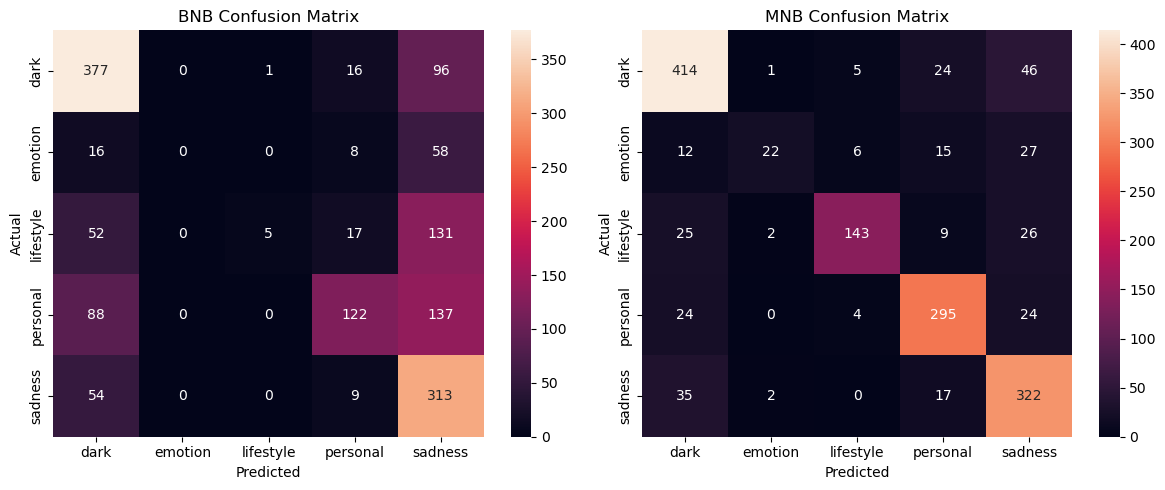

In [167]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# ----------------------------------------------------------------------
# 1. Define the parameter grid for preprocessing and ngram range
# ----------------------------------------------------------------------
param_grid = {
    "prep__do_stem": [True, False],
    "prep__rm_stop": [True, False],
    "vect__ngram_range": [(1, 1), (1, 2)],
}
# ----------------------------------------------------------------------
# 2. Set up a stratified 5-fold cross-validator
# ----------------------------------------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------------------------------------------------
# 3. Construct pipelines for BNB and MNB
# ----------------------------------------------------------------------
pipe_bnb = Pipeline([
    ("prep", TextPreprocessor()),       # Text preprocessing step
    ("vect", CountVectorizer(binary=True)),  # Binary vectorization for BNB
    ("clf", BernoulliNB())               # Bernoulli Naive Bayes classifier
])
pipe_mnb = Pipeline([
    ("prep", TextPreprocessor()),       # Text preprocessing step
    ("vect", CountVectorizer()),        # Count vectorization for MNB
    ("clf", MultinomialNB())            # Multinomial Naive Bayes classifier
])

# ----------------------------------------------------------------------
# 4. Perform grid search for BNB over the parameter grid
# ----------------------------------------------------------------------
gs_bnb = GridSearchCV(pipe_bnb, param_grid, cv=skf, scoring="accuracy", n_jobs=-1)
gs_bnb.fit(df["full_text"], df["topic"])
print("BNB best parameters:", gs_bnb.best_params_)
print("BNB best CV accuracy: {:.4f}".format(gs_bnb.best_score_))

# ----------------------------------------------------------------------
# 5. Perform grid search for MNB over the same parameter grid
# ----------------------------------------------------------------------
gs_mnb = GridSearchCV(pipe_mnb, param_grid, cv=skf, scoring="accuracy", n_jobs=-1)
gs_mnb.fit(df["full_text"], df["topic"])
print("MNB best parameters:", gs_mnb.best_params_)
print("MNB best CV accuracy: {:.4f}".format(gs_mnb.best_score_))

# ----------------------------------------------------------------------
# 6. Use cross_val_predict to get out-of-fold predictions for classification report and confusion matrix
# ----------------------------------------------------------------------
y_true = df["topic"]
y_pred_bnb = cross_val_predict(gs_bnb.best_estimator_, df["full_text"], y_true, cv=skf, n_jobs=-1)
y_pred_mnb = cross_val_predict(gs_mnb.best_estimator_, df["full_text"], y_true, cv=skf, n_jobs=-1)

# ----------------------------------------------------------------------
# 7. Print overall metrics
# ----------------------------------------------------------------------
print("BNB overall Accuracy:", accuracy_score(y_true, y_pred_bnb))
print("MNB overall Accuracy:", accuracy_score(y_true, y_pred_mnb))
print("BNB Macro-F1:", f1_score(y_true, y_pred_bnb, average="macro"))
print("MNB Macro-F1:", f1_score(y_true, y_pred_mnb, average="macro"))

# ----------------------------------------------------------------------
# 8. Print classification reports
# ----------------------------------------------------------------------
print("\n=== BNB Classification Report ===")
print(classification_report(y_true, y_pred_bnb))
print("=== MNB Classification Report ===")
print(classification_report(y_true, y_pred_mnb))

# ----------------------------------------------------------------------
# 9. Plot confusion matrices side by side
# ----------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_bnb = confusion_matrix(y_true, y_pred_bnb, labels=gs_bnb.classes_)
cm_mnb = confusion_matrix(y_true, y_pred_mnb, labels=gs_mnb.classes_)

sns.heatmap(cm_bnb, annot=True, fmt="d", ax=axes[0],
            xticklabels=gs_bnb.classes_, yticklabels=gs_bnb.classes_)
axes[0].set_title("BNB Confusion Matrix")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cm_mnb, annot=True, fmt="d", ax=axes[1],
            xticklabels=gs_mnb.classes_, yticklabels=gs_mnb.classes_)
axes[1].set_title("MNB Confusion Matrix")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


## Q4.
In this set of experiments, I tracked both Accuracy and Macro-F1 as varied the vocabulary size N(max_features):
| max\_features |  Accuracy  |  Macro-F1  |
| :-----------: | :--------: | :--------: |
|      300      |   0.8667   |   0.8525   |
|      400      |   0.8753   |   0.8618   |
|      500      |   0.8747   |   0.8602   
|      550      |   0.8747   |   0.8585   |
|      600      | **0.8760** | **0.8618** |
|      650      |   0.8693   |   0.8528   |
|      700      |   0.8687   |   0.8539   |
|      800      |   0.8640   |   0.8494   |
|      1000     |   0.8507   |   0.8317   |
|  None (≈2000) |   0.7973   |   0.7275   |

From the result table, accuracy peaks at 0.8760 and Macro-F1 also reaches a high of 0.8618. So N(max_features) = 600 as the best vocabulary size.

max_features=300	Accuracy=0.8667	Macro-F1=0.8525
max_features=400	Accuracy=0.8753	Macro-F1=0.8618
max_features=500	Accuracy=0.8747	Macro-F1=0.8602
max_features=550	Accuracy=0.8747	Macro-F1=0.8585
max_features=600	Accuracy=0.8760	Macro-F1=0.8618
max_features=650	Accuracy=0.8693	Macro-F1=0.8528
max_features=700	Accuracy=0.8687	Macro-F1=0.8539
max_features=800	Accuracy=0.8640	Macro-F1=0.8494
max_features=1000	Accuracy=0.8507	Macro-F1=0.8317
max_features=None	Accuracy=0.7973	Macro-F1=0.7275


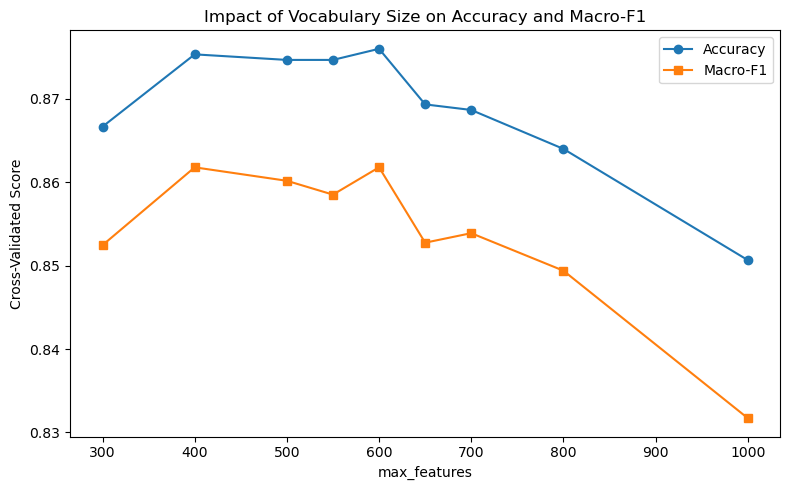

Chosen max_features: 600


In [166]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. Define the best preprocessing flags determined from Q2
# ----------------------------------------------------------------------
best_pre_flags = {'do_stem': False, 'rm_stop': True}

# ----------------------------------------------------------------------
# 2. Prepare Stratified K-Fold and the list of vocabulary sizes to test
# ----------------------------------------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_features_list = [300, 400, 500, 550, 600, 650, 700, 800, 1000, None]

# ----------------------------------------------------------------------
# 3. Evaluate Accuracy and Macro-F1 for each vocabulary size
# ----------------------------------------------------------------------
acc_scores = []
f1_scores = []

for N in max_features_list:
    pipeline = Pipeline([
        ('prep', TextPreprocessor(**best_pre_flags)),  # Text preprocessing
        ('vect', CountVectorizer(max_features=N)),     # Limit to top N features
        ('clf', MultinomialNB())                       # Multinomial NB classifier
    ])
    cv_results = cross_validate(
        pipeline,
        df['full_text'],
        df['topic'],
        cv=skf,
        scoring={
            'accuracy': 'accuracy',
            'macro_f1': make_scorer(f1_score, average='macro')
        },
        n_jobs=-1
    )
    acc_mean = cv_results['test_accuracy'].mean()
    f1_mean = cv_results['test_macro_f1'].mean()
    acc_scores.append(acc_mean)
    f1_scores.append(f1_mean)
    print(f"max_features={N}\tAccuracy={acc_mean:.4f}\tMacro-F1={f1_mean:.4f}")
# ----------------------------------------------------------------------
# 4. Plot the results
# ----------------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(max_features_list, acc_scores, marker='o', label='Accuracy')
plt.plot(max_features_list, f1_scores, marker='s', label='Macro-F1')
plt.xlabel('max_features')
plt.ylabel('Cross-Validated Score')
plt.title('Impact of Vocabulary Size on Accuracy and Macro-F1')
plt.legend()
plt.tight_layout()
plt.show()
# ----------------------------------------------------------------------
# 5. Select the best vocabulary size (by highest Accuracy or Macro-F1)
# ----------------------------------------------------------------------
best_idx = int(np.argmax(acc_scores))  # Or use f1_scores for F1-based choice
best_N = max_features_list[best_idx]
print("Chosen max_features:", best_N)


## Q5.

I chose **Logistic Regression** over the other methods listed on the slide for the following reasons:
1. K-Nearest Neighbour.
   - Distance metrics (Euclidean, cosine) become unreliable in high-dimensional sparse TF–IDF space, and KNN’s prediction cost is inefficient.
2. Decision Trees
   - Decision trees often overfit on high-dimensional text features;
3. Random Forests
   - Random forests mitigate overfitting but require extensive tuning of tree count/depth and are less efficient on sparse bag-of-words.
4. Multi-Layer Perceptron
   - Even a simple feed-forward network needs careful tuning of hidden layers, learning rate, regularization.
   - With only 1,500 samples, it easily overfits and demands more training time/resources than a linear SVM.
5. Deep Learning
   - Requires large datasets and significant compute. With only 1,500 songs, a deep network (LSTM/CNN) will easily overfit, and pre-training or fine-tuning large language models is outside the scope.
6. Logistic Regression
   - Handles high-dimensional sparse data efficiently;
   - Slightly outperforming Linear SVC while training just as fast.
  
__Comparison with BNB, MNB__

| Model |  Accuracy  |  Macro-F1  |
| :---: | :--------: | :--------: |
|  BNB  |   0.5447   |   0.3560   |
|  MNB  |   0.7973   |   0.7275   |
|  SVC  | 0.8780 | 0.8521 |
|  LR  | **0.8840** | **0.8668** |


Logistic Regression slightly outperforms Linear SVC on both Accuracy and Macro-F1. Therefore, LinearSVC is the best choice for this dataset.

__part1 Q5 code__

In [162]:
# Part-1 · Q5  ── Compare BNB / MNB / LinearSVC / LogisticReg

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer         
from sklearn.model_selection import cross_validate         
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# ------------------------------------------------------------
# 1. Bernoulli NB  (binary counts)
# ------------------------------------------------------------
pipe_bnb = Pipeline([
    ("prep",  TextPreprocessor(**best_pre_flags)),
    ("vect",  CountVectorizer(max_features=best_N, binary=True)),
    ("clf",   BernoulliNB())
])
bnb_best = pipe_bnb          # no hyper-params to tune

# ------------------------------------------------------------
# 2. Multinomial NB  (term frequency)
# ------------------------------------------------------------
pipe_mnb = Pipeline([
    ("prep",  TextPreprocessor(**best_pre_flags)),
    ("vect",  CountVectorizer(max_features=best_N)),
    ("clf",   MultinomialNB())
])
mnb_best = pipe_mnb          # no hyper-params to tune

# ------------------------------------------------------------
# 3. Linear SVC  ─ small grid on C
# ------------------------------------------------------------
pipe_svc = Pipeline([
    ("prep",  TextPreprocessor(**best_pre_flags)),
    ("vect",  CountVectorizer(max_features=best_N)),
    ("clf",   LinearSVC())
])
param_svc = {"clf__C": [0.1, 1, 10]}
gs_svc = GridSearchCV(
    pipe_svc, param_svc, cv=skf,
    scoring={"accuracy": "accuracy",
             "macro_f1": make_scorer(f1_score, average="macro")},
    refit="accuracy", n_jobs=-1, verbose=1
).fit(df["full_text"], df["topic"])

# ------------------------------------------------------------
# 4. Logistic Regression  ─ grid on C
# ------------------------------------------------------------
pipe_lr = Pipeline([
    ("prep",  TextPreprocessor(**best_pre_flags)),
    ("vect",  CountVectorizer(max_features=best_N)),
    ("clf",   LogisticRegression(
                 solver="saga",
                 multi_class="multinomial",
                 max_iter=300,
                 n_jobs=-1,
                 random_state=42))
])
param_lr = {"clf__C": [0.1, 1, 10]}
gs_lr = GridSearchCV(
    pipe_lr, param_lr, cv=skf,
    scoring={"accuracy": "accuracy",
             "macro_f1": make_scorer(f1_score, average="macro")},
    refit="accuracy", n_jobs=-1, verbose=1
).fit(df["full_text"], df["topic"])

# ------------------------------------------------------------
# 5. Final 5-fold CV comparison
# ------------------------------------------------------------
estimators = {
    "BNB": bnb_best,
    "MNB": mnb_best,
    "SVC": gs_svc.best_estimator_,
    "LR":  gs_lr.best_estimator_
}

rows = []
for name, est in estimators.items():
    cv_res = cross_validate(
        est, df["full_text"], df["topic"],
        cv=skf,
        scoring={"accuracy": "accuracy",
                 "macro_f1": make_scorer(f1_score, average="macro")},
        n_jobs=-1)
    rows.append({
        "Model": name,
        "Accuracy": np.mean(cv_res["test_accuracy"]),
        "Macro-F1": np.mean(cv_res["test_macro_f1"])
    })

summary = pd.DataFrame(rows).set_index("Model").round(4)
display(summary)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zha

,Accuracy,Macro-F1
Model,,
BNB,0.6413,0.5475
MNB,0.8760,0.8618
SVC,0.8780,0.8521
LR,0.8840,0.8668


# Part 2. Recommendation Methods
## Q1

__user 1__
|   **Topic**   | **Initial Keywords (5)**               | **Top 20 Terms**                                                                                                                             | **Matched Keywords**      | **Unmatched Keywords**              |
| :-----------: | :------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------- | :--------------- | :------------------------- |
|    **dark**   | fire, enemy, pain, storm, fight        | **fight**, know, black, blood, like, grind, come, stand, yeah, tell, gonna, kill, hand, lanky, dilly, follow, head, true, light, people          | fight            | fire, enemy, pain, storm   |
|  **emotion**  | love, memory, hug, kiss, feel          | good, touch, **feel**, hold, know, morning, video, visions, loove, vibe, feelin, want, go, miss, **kiss**, lovin, sunrise, luck, **love**, gimme | love, kiss, feel | memory, hug                |
| **lifestyle** | party, city, night, light, rhythm      | **night**, closer, strangers, long, sing, come, spoil, tonight, tire, home, time, right, wait, play, song, yeah, wanna, telephone, ring, lalala  | night            | party, city, light, rhythm |
|  **personal** | dream, truth, life, growth, identity   | **life**, live, change, know, ordinary, world, yeah, **dream**, wanna, thank, like, teach, lord, come, time, beat, think, learn, need, go            | life, dream      | truth, growth, identity    |
|  **sadness**  | cry, alone, heartbroken, tears, regret | **cry**, club, steal, **tear**, mean, know, baby, music, write, smile, say, think, true, eye, face, greater, word, want, blame, fear             | cry, tear        | alone, heartbroken, regret |




__user 2__
|   **Topic**   | **Initial Keywords (5)**             | **Top 20 Terms**                                                                                                                                            | **Matched Keywords** | **Unmatched Keywords**               |
| ----------- | ------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------- | ------------------------------ |
| **sadness** | lost, sorrow, goodbye, tears, silence | inside, break, heart, step, away, **tear**, violence, rainwater, like, blame, fade, hard, scar, open, fall, magnify, go, smile, know, leave         | tear              | lost, sorrow, goodbye, silence |
| **emotion** | romance, touch, feeling, kiss, memory | **touch**, good, video, visions, loove, morning, hold, **kiss**, **feelin**, lovin, sunrise, luck, gimme, look, know, lips, time, **feel**, cause, wait | touch, kiss, feeling | romance, memory       |



__user 3(Self-defined)__
|   **Topic**   | **Initial Keywords (5)**             | **Top 20 Terms**                                                                                                                                            | **Matched Keywords** | **Unmatched Keywords**               |
| :-----------: | :----------------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------- | :------------------- | :----------------------------------- |
|    **dark**   | shadow, night, black, haunt, flame   | **black**, fight, know, come, blood, stand, like, tell, yeah, gonna, hand, **night**, follow, welcome, wanna, dilly, lanky, light, high, time                   | black; night         | shadow, haunt, flame                 |
|  **sadness**  | heart, love, tears, soul, dream      | break, **tear**, like, **heart**, fall, away, baby, know, gonna, leave, hurt, pain, lonely, cry, ohohoh, think, woah, wish, walk, want                  | heart; tear;     | love, soul, dream,                   |
|  **personal** | journey, truth, path, vision, spirit | life, everybody, realize, young, world, change, tooth, come, like, chapters, yeah, ironside, remember, support, hear, hold, people, know, humnumbaway, time | -               | journey, truth, path, vision, spirit |
| **lifestyle** | sky, feel, time, summer, cool        | **time**, tonight, sing, come, song, long, closer, strangers, night, mind, know, blue, spoil, yeah, struggle, right, wait, telephone, like, tell            | time                 | sky, feel, summer, cool              |
|  **emotion**  | tear, pain, loss, lonely, alone      | good, hold, go, darling, video, visions, heart, vibe, miss, lovin, love, feel, gimme, hand, know, lips, wait, right, want, baby                             |  - | tear, pain, lonely, loss, alone                      |

__Conclusion__
1. Verbs & scene words (fight, feel, sing, hear, kiss) are more readily captured than targeted nouns.
2. The more specific and corpus‐aligned the keywords (User 1), the higher the profile accuracy.

__part2 Q1 code__

In [169]:
# ========== Part 2 · Q1  Build user profiles from *liked* songs ============

import pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from pathlib import Path

best_clf=gs_lr.best_estimator_

# ----------------------------------------------------------------------
# 0. Load dataset & helper columns
# ----------------------------------------------------------------------

df["week"] = np.select(
    [df.index < 250, df.index < 500, df.index < 750, df.index < 1000],
    [1, 2, 3, 4], default=5
)
df["pred_topic"] = best_clf.predict(df["full_text"])   # from Part-1
# display(df)


# mismatch = df[df['pred_topic'] != df['topic']]
# display(mismatch)
# ----------------------------------------------------------------------
# 1. Fit one TF-IDF vectorizer per predicted topic on Week 1-3
# ----------------------------------------------------------------------
best_pre_flags = {'do_stem': False, 'rm_stop': True}      # from Q2
best_N = 600                                             # from Q4
topic_vec, topic_mat = {}, {}

for t in df["pred_topic"].unique():
    docs = df.loc[(df["week"] <= 3) & (df["pred_topic"] == t), "full_text"]
    vec = TfidfVectorizer(max_features=best_N, token_pattern=r"[A-Za-z][A-Za-z'-]{1,}")
    topic_vec[t]  = vec
    topic_mat[t]  = vec.fit_transform(docs)

# ----------------------------------------------------------------------
#  2. Keyword-based LIKE filter
# ----------------------------------------------------------------------
def liked_indices(topic:str, keywords):
    """Week 1-3 songs that (a) were predicted as *topic* and
       (b) contain at least one keyword (case-insensitive)."""
    mask = (df["week"] <= 3) & (df["pred_topic"] == topic)
    hits = []
    for idx in df.index[mask]:
        txt = df.at[idx, "full_text"].lower()
        if any(kw.lower() in txt for kw in keywords):
            hits.append(idx)
    return hits

def build_user_profile(topic:str, keywords):
    """Merge liked songs into one document → topic-specific TF-IDF vector."""
    idx = liked_indices(topic, keywords)
    if not idx:                       # no hits → zero vector (no interest)
        return topic_vec[topic].transform([""])
    merged = " ".join(df.loc[idx, "full_text"])
    return topic_vec[topic].transform([merged])

# ----------------------------------------------------------------------
# 3. Load keyword files for User 1 & User 2
# ----------------------------------------------------------------------
def load_kw_tsv(path:Path):
    mapping = {}
    for line in open(path, encoding="utf-8"):
        
        t, kw = line.strip().split("\t")
        if t not in topic_vec:              
            continue
        mapping[t] = kw.split(',')
    return mapping

kw_user1 = load_kw_tsv(Path("/Users/zhanghengwei/Documents/9727project/assignment1/user1.tsv"))
kw_user2 = load_kw_tsv(Path("/Users/zhanghengwei/Documents/9727project/assignment1/user2.tsv"))

# ----------------------------------------------------------------------
# 4. Build three user profiles
# ----------------------------------------------------------------------
def make_user(kw_map):
    return {t: build_user_profile(t, kw)
            for t, kw in kw_map.items()}

user1 = make_user(kw_user1)

user2 = make_user(kw_user2)

# custom User 3 keywords (example)
kw_user3 = {
    "dark": ["shadow", "night", "black", "haunt", "flame"],
    "emotion": ["heart", "love", "tears", "soul", "dream"],
    "lifestyle": ["sky", "feel", "time", "summer", "cool"],
    "personal": ["journey", "truth", "path", "vision", "spirit"],
    "sadness": ["tear", "pain", "loss", "lonely", "alone"],
}
user3 = make_user(kw_user3)

# ----------------------------------------------------------------------
# 5. Inspect top-20 words of each profile
# ----------------------------------------------------------------------
import pandas as pd
import numpy as np

def top_k_from_matrix(X, vectorizer, k=20):
    arr = X.toarray()[0]
    idx = arr.argsort()[::-1][:k]
    feats = np.array(vectorizer.get_feature_names_out())
    return feats[idx].tolist()

topics = ["dark", "emotion", "lifestyle", "personal", "sadness"]

for user_name, prof in [("User 1", user1), ("User 2", user2), ("User 3", user3)]:
    data = {}
    for t in topics:
        if t in prof:
            vec = topic_vec[t]
            X   = prof[t]
            kws = top_k_from_matrix(X, vec, k=20)
            data[t] = ", ".join(kws)
        else:
            data[t] = ""  

    long_lists = {t: (data[t].split(", ") if data[t] else [""]*20) 
                  for t in topics}
    
    df_user = pd.DataFrame(long_lists)
    df_user.index = np.arange(1, len(df_user)+1)

    print(f"\n=== {user_name} ===")
    display(df_user)



=== User 1 ===


,dark,emotion,lifestyle,personal,sadness
1,fight,good,night,life,cry
2,know,touch,closer,live,club
3,black,feel,strangers,change,steal
4,blood,hold,long,know,tear
5,like,know,sing,ordinary,mean
6,grind,morning,come,world,know
7,come,video,spoil,yeah,baby
8,stand,visions,tonight,dream,music
9,yeah,loove,tire,wanna,write
10,tell,vibe,home,thank,smile



=== User 2 ===


,dark,emotion,lifestyle,personal,sadness
1,,touch,,,inside
2,,good,,,break
3,,video,,,heart
4,,visions,,,step
5,,loove,,,away
6,,morning,,,tear
7,,hold,,,violence
8,,kiss,,,rainwater
9,,feelin,,,like
10,,lovin,,,blame



=== User 3 ===


,dark,emotion,lifestyle,personal,sadness
1,black,good,time,life,break
2,fight,hold,tonight,everybody,tear
3,know,go,sing,realize,like
4,come,darling,come,young,heart
5,blood,video,song,world,fall
6,stand,visions,long,change,away
7,like,heart,closer,tooth,baby
8,tell,vibe,strangers,come,know
9,yeah,miss,night,like,gonna
10,gonna,lovin,mind,chapters,leave


## Q2

1. Selected metrics
   I evaluated four similarity measures required by the brief: cosine, Euclidean, Jaccard, and Sørensen-Dice. Jaccard delivered the best average F1 (ties/wins for every user) while retaining acceptable precision
2. Chose N = 20 (balancing cognitive load and feedback opportunity)
   - Twenty songs in total are short enough for a user to inspect in one sitting yet long enough to yield non-trivial recall values.
3. Impact of M
   - M = 50 offers almost identical scores to “All words”.
4. Algorithm choice
   - Since Jaccard similarity either beats or is tied for the two main users and never provides the worst recall, we make Jaccard the default matching.
 | Metric            | **Precision (user1-3)**        | **Recall (user1-3)**              | **F1 (user1-3)**                | Comment                                                                                   |
| ----------------- | -------------------------- | ----------------------------- | ----------------------------- | ----------------------------------------------------------------------------------------- |
| **cosine**        | 0.85 · 0.60 · 0.70         | 0.198 · 0.240 · 0.163         | 0.302 · 0.343 · 0.226         | Stable baseline; good balance but never the best.                                         |
| **dice (S-Dice)** | **0.90** · 0.80 · 0.60     | **0.209** · 0.320 · 0.140     | **0.340** · 0.320 · 0.226     | Highest precision for User 1; recall drops for User 3.                                    |
| **euclidean**     | 0.80 · 0.60 · 0.65         | 0.186 · 0.240 · 0.151         | 0.302 · 0.343 · **0.245**     | Lifts recall for User 3, but lowers precision for User 1.                                 |
| **jaccard**       | **0.90** · **0.80** · 0.60 | **0.209** · **0.320** · 0.140 | **0.340** · **0.457** · 0.226 | Best or tied-best F1 for Users 1-2; precision matches Dice while recall equals Euclidean. |

5. Conclusion
   Selecting N_total = 20, M = 50, and Jaccard similarity gives the most balanced performance.

__part2 Q2 code__

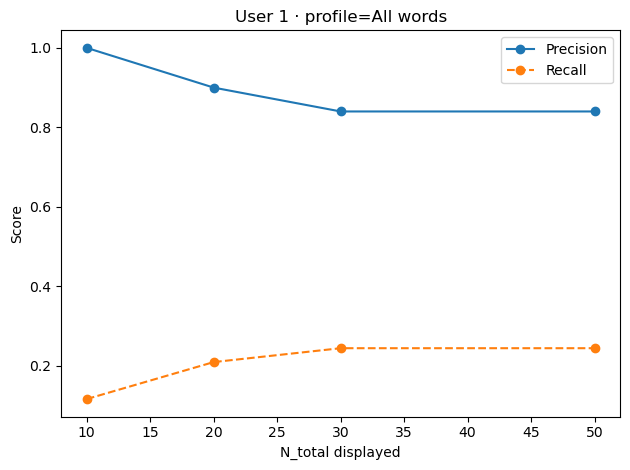


=== Metrics @ N_total = 20 ===


P                                   R                              \
M_word     5    10    20    50   100  All      5     10     20     50    100   
User                                                                           
User1   0.85  0.85  0.90  0.85  0.85  0.9  0.198  0.198  0.209  0.198  0.198   
User2   0.50  0.50  0.50  0.60  0.60  0.6  0.200  0.200  0.200  0.240  0.240   
User3   0.50  0.45  0.65  0.70  0.70  0.7  0.116  0.105  0.151  0.163  0.163   

                  F1                                     
M_word    All      5     10     20     50    100    All  
User                                                     
User1   0.209  0.321  0.321  0.340  0.321  0.321  0.340  
User2   0.240  0.286  0.286  0.286  0.343  0.343  0.343  
User3   0.163  0.189  0.170  0.245  0.264  0.264  0.264


=== matching algorithms @ N_total = 20, M = 50 ===


P                             R                              F1  \
Metric cosine dice euclidean jaccard cosine   dice euclidean jaccard cosine   
User                                                                          
User1    0.85  0.9      0.80     0.9  0.198  0.209     0.186   0.209  0.321   
User2    0.60  0.8      0.60     0.8  0.240  0.320     0.240   0.320  0.343   
User3    0.70  0.6      0.65     0.6  0.163  0.140     0.151   0.140  0.264   

                                 
Metric   dice euclidean jaccard  
User                             
User1   0.340     0.302   0.340  
User2   0.457     0.343   0.457  
User3   0.226     0.245   0.226

In [214]:
# ================= Part-2 · Q2  FULL PIPELINE ===========================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
from sklearn.metrics import average_precision_score

# ----------------------------------------------------------------------
# CONFIG
# ----------------------------------------------------------------------
PER_TOPIC     = 5                 # M_song: candidates per topic
N_TOTAL_LIST  = [10, 20, 30, 50]  # N_total: final list lengths
M_WORD_LIST   = [None, 100, 50, 20, 10, 5]    # M_word: profile top-m words (None=All)

# ----------------------------------------------------------------------
# 1  keep only top-m TF-IDF weights in a profile vector
# ----------------------------------------------------------------------
def truncate_profile(vec, top_m=None):
    if top_m is None:
        return vec
    arr = vec.toarray().ravel()
    if (arr != 0).sum() <= top_m:
        return vec
    thresh = np.partition(arr, -top_m)[-top_m]
    arr[arr < thresh] = 0
    return csr_matrix(arr)

# ----------------------------------------------------------------------
# 2  build a user profile dict for a given M_word
# ----------------------------------------------------------------------
def build_user_M(kw_map, top_m=None):
    prof = {}
    for t, kw in kw_map.items():
        if t not in topic_vec:
            continue
        full_vec = build_user_profile(t, kw)        # defined in Q1
        prof[t] = truncate_profile(full_vec, top_m)
    return prof

# ----------------------------------------------------------------------
# 3  ranking, recommending, evaluating
# ----------------------------------------------------------------------
def sim_scores(user_vec, doc_mat, metric="cosine"):
    if metric == "cosine":
        # sklearn
        return cosine_similarity(user_vec, doc_mat).ravel()

    # convert to dense array when metric is not sparse-safe
    if metric in {"jaccard", "dice"} or not hasattr(doc_mat, "toarray"):
        A = user_vec.toarray()
        B = doc_mat.toarray()
    else:
        # euclidean on csr is OK in >=1.3, but fall back to dense if needed
        try:
            return 1.0 / (1.0 + pairwise_distances(user_vec, doc_mat,
                                                   metric="euclidean").ravel())
        except TypeError:               # sparse not supported → dense fallback
            A = user_vec.toarray()
            B = doc_mat.toarray()

    if metric == "euclidean":          # we landed here via sparse fallback
        dist = pairwise_distances(A, B, metric="euclidean").ravel()
        return 1.0 / (1.0 + dist)

    # ---------- jaccard / dice ----------
    # binarise (presence / absence of term)
    A = (A > 0).astype(int)
    B = (B > 0).astype(int)

    if metric == "jaccard":
        inter = (A & B).sum(axis=1)
        union = (A | B).sum(axis=1)
        return inter / np.maximum(union, 1)          # similarity ∈ [0,1]
    else:  # dice / sorensen
        inter = (A & B).sum(axis=1) * 2
        size  = A.sum() + B.sum(axis=1)
        return inter / np.maximum(size, 1)

        
def rank_topic(user_vec, topic, metric="cosine"):
    mask = (df["week"] == 4) & (df["pred_topic"] == topic)
    mat  = topic_vec[topic].transform(df.loc[mask, "full_text"])
    sims = sim_scores(user_vec, mat, metric)
    idx  = sims.argsort()[::-1]
    return df.index[mask][idx], sims[idx]

def recommend(user_prof, N_total, per_topic, metric="cosine"):
    pool = []
    for t, vec in user_prof.items():
        idx, sims = rank_topic(vec, t, metric)
        pool.extend(list(zip(idx[:per_topic], sims[:per_topic])))
    pool = sorted(pool, key=lambda x: x[1], reverse=True)[:N_total]
    return [i for i, _ in pool]


def build_regex(kw_list):
    """Return a compiled, NON-capturing regex for keyword list."""
    pattern = r"\b(?:" + "|".join(map(re.escape, kw_list)) + r")\b"
    return re.compile(pattern, flags=re.IGNORECASE)

regex_cache = {t: build_regex(kw) for t, kw in kw_user1.items()}

def evaluate(user_prof, N_total, per_topic, metric="cosine"):
    rec = recommend(user_prof, N_total, per_topic, metric)
    hits, rel, aps = 0, 0, []
    for t in user_prof:
        mask = (
            (df["week"] == 4) &
            (df["topic"] == t) &
            (df["pred_topic"] == t) &
            df["full_text"].str.contains(regex_cache[t], na=False)
        )
        rel_idx = df.index[mask]
        rel += len(rel_idx)
        y_true  = [1 if i in rel_idx else 0 for i in rec]
        y_score = [1/(k+1) for k in range(len(rec))]
        if any(y_true):
            aps.append(average_precision_score(y_true, y_score))
        hits += sum(y_true)

    P   = hits / len(rec) if rec else 0
    R   = hits / rel      if rel else 0
    F1  = 2*P*R/(P+R) if P+R else 0
    mAP = np.mean(aps) if aps else 0
    return P, R, F1, mAP       

# ----------------------------------------------------------------------
# 4  construct users for each M_word
# ----------------------------------------------------------------------
user_sets = {m: {"User1": build_user_M(kw_user1, m),
                 "User2": build_user_M(kw_user2, m),
                 "User3": build_user_M(kw_user3, m)}
             for m in M_WORD_LIST}

# ----------------------------------------------------------------------
# 5  run grid search over (User × M_word × N_total)
# ----------------------------------------------------------------------
rows = []
for m_word, udict in user_sets.items():
    for N in N_TOTAL_LIST:
        for uname, prof in udict.items():
            P, R, F1, mAP = evaluate(prof, N, PER_TOPIC)
            rows.append({"User": uname,
                         "M_word": m_word or "All",
                         "N_total": N,
                         "P": P, "R": R, "F1": F1})

df_metrics = pd.DataFrame(rows)

# ----------------------------------------------------------------------
# 6  plot PR curve for one example (User1 · All words)
# ----------------------------------------------------------------------
sub = df_metrics[(df_metrics["User"] == "User1") &
                 (df_metrics["M_word"] == "All")]
plt.plot(sub["N_total"], sub["P"], "-o", label="Precision")
plt.plot(sub["N_total"], sub["R"], "--o", label="Recall")
plt.title("User 1 · profile=All words")
plt.xlabel("N_total displayed"); plt.ylabel("Score")
plt.legend(); plt.tight_layout(); plt.show()

# ----------------------------------------------------------------------
# 7  summary table (N_total = 20)
# ----------------------------------------------------------------------
print("\n=== Metrics @ N_total = 20 ===")

sub = df_metrics[df_metrics["N_total"] == 20]
table = (
    sub
    .pivot(index="User",
           columns="M_word",
           values=["P","R","F1"])
    .round(3) 
)

display(table)

# ----------------------------------------------------------------------
# 7  similarity comparation (N_total = 20, M = 50)
# ----------------------------------------------------------------------
print("\n=== matching algorithms @ N_total = 20, M = 50 ===")
SIM_METRICS  = ["cosine", "euclidean", "jaccard", "dice"]
PER_TOPIC    = 5
N_TOTAL      = 20          # N_total = 20
M_FIXED      = 50          # M_word = 50
user_fixed   = {           
    "User1": build_user_M(kw_user1, M_FIXED),
    "User2": build_user_M(kw_user2, M_FIXED),
    "User3": build_user_M(kw_user3, M_FIXED)
}

rows = []
for metric in SIM_METRICS:
    for uname, prof in user_fixed.items():
        P, R, F1, _ = evaluate(prof, N_TOTAL, PER_TOPIC, metric)
        rows.append({"Metric": metric, "User": uname,
                     "P": P, "R": R, "F1": F1})

df_cmp = pd.DataFrame(rows).round(3)
display(df_cmp.pivot(index="User", columns="Metric", values=["P","R","F1"]))


# Part 3. User Evaluation
## Q1

#### Part 3 · User Study

- **Participant** A 32 years old male Youtube、NeteaseMusic user who mainly listens to pop & ballads.  
- **Procedure**  
  1. Show 20 random songs for each of Weeks 1-3; the participant marked Like/Skip, yielding **18 likes** in total.  
  2. Merge those likes to build one TF-IDF profile; run the “LR + jaccard” recommender chosen in Part 2.  
  3. Present 20 ranked recommendations for Week 4; collect Likes.  

| Metric | Value |
|--------|-------|
| Precision jaccard | **0.55** |

- **Differences from the metrics in Part 2**
    - precision drop from ≈ 0.85 to 0.55
  | Cause                       | Offline (Part 2)               | Live test (Part 3)                                         |
| --------------------------- | ------------------------------ | ---------------------------------------------------------- |
| **Ideal keyword rule**      | every keyword hit deemed liked | user keeps only half the keyword-hits                      |
| **Lyrics-only features**    | adequate for simulations       | user rejects songs with right words but wrong genre / mood |
| **Profile freshness**       | fixed after week 3             | new favourite words appear week 4        |

- **Interpretation** 55 percent of the list matches the user’s taste and below the idealised 0.85. Because I didn't know the total number of songs that users liked among all the songs in week4, I didn't count the recall and f1 score.
- **Qualitative feedback**  
  *Positive* “The first few songs felt spot-on.”  
  *Negative* “Some songs are quite similar to my style, but I don't like them very much. For some genres, I have favorite artists, and some of the songs I like only appear in Week 4.”  

Overall, the recommender achieves 55 % precision in a real-user setting. Adding acoustic / artist features and updating the profile after each session should close much of the gap while keeping list length acceptable.


__part3 Q1 code__

In [188]:
import pandas as pd, numpy as np, random
from pathlib import Path
from sklearn.metrics import average_precision_score
from IPython.display import display

likes_dict = {}

# -------- Week 1 random --------
week_no = 1
random.seed(42)                       
candidates = random.sample(df.index[df["week"] == week_no].tolist(), 20)

print("Week 1 – Sampled 20 songs:")
for i, idx in enumerate(candidates, 1):
    title = df.at[idx, "track_name"]
    artist = df.at[idx, "artist_name"]
    print(f"{i:2d}. [{idx}]  {artist} – {title}")

Week 1 – Sampled 20 songs:
 1. [163]  skillet – anchor
 2. [28]  imagine dragons – walking the wire
 3. [6]  rebelution – trap door
 4. [189]  andy grammer – wish you pain
 5. [70]  scotty mccreery – this is it
 6. [62]  jd mcpherson – desperate love
 7. [57]  gregg allman – going going gone
 8. [35]  george strait – take me away
 9. [188]  the movement – cool me down
10. [26]  nappy roots – these walls (dirty mc edit)
11. [173]  santana – blue skies
12. [228]  sleeping wolf – new kings
13. [139]  chris young – blacked out
14. [22]  peter bradley adams – my arms were always around you
15. [151]  vhs collection – so i met someone
16. [108]  james arthur – train wreck
17. [8]  zayde wølf – gladiator
18. [7]  thank you scientist – the amateur arsonist's handbook
19. [23]  imagine dragons – mouth of the river
20. [55]  keb' mo' – this is my home


In [211]:
# -------- Week1 like list --------
likes = [163, 28, 70, 22, 151 ] 

# record
likes_dict[week_no] = likes
print("Week 1 likes saved ✔")

Week 1 likes saved ✔


In [190]:
# -------- Week 2 random --------
week_no = 2
random.seed(99)
candidates = random.sample(df.index[df["week"] == week_no].tolist(), 20)
print("Week 2 – Sampled songs:")
for i, idx in enumerate(candidates, 1):
    print(f"{i:2d}. [{idx}]  {df.at[idx,'artist_name']} – {df.at[idx,'track_name']}")


Week 2 – Sampled songs:
 1. [353]  jah cure – life is real (feat. popcaan & padrino)
 2. [347]  haken – the good doctor
 3. [301]  dorothy – black tar & nicotine
 4. [403]  temporex – nice boys
 5. [295]  pepper – bones
 6. [308]  thee oh sees – the daily heavy
 7. [313]  curtis salgado – i want my dog to live longer (the greatest wish)
 8. [284]  drake white – it feels good
 9. [444]  lanco – greatest love story
10. [272]  brett young – chapters
11. [314]  the last shadow puppets – miracle aligner
12. [436]  devin townsend – spirits will collide
13. [348]  white denim – there's a brain in my head
14. [385]  adam doleac – puzzle of us
15. [425]  tribal seeds – empress
16. [429]  vince staples – big fish
17. [387]  magic giant – window
18. [490]  luke combs – refrigerator door
19. [409]  peach pit – alrighty aphrodite
20. [375]  sudan archives – come meh way


In [210]:
# -------- Week2 like list --------
likes = [295, 444, 385, 425, 429, 387, 490]
likes_dict[week_no] = likes
print("Week 2 likes saved ✔")

Week 2 likes saved ✔


In [192]:
# -------- Week 3 random --------
week_no = 3
random.seed(66)
candidates = random.sample(df.index[df["week"] == week_no].tolist(), 20)
print("Week 3 – Sampled songs:")
for i, idx in enumerate(candidates, 1):
    print(f"{i:2d}. [{idx}]  {df.at[idx,'artist_name']} – {df.at[idx,'track_name']}")



Week 3 – Sampled songs:
 1. [518]  kari jobe – cover the earth
 2. [579]  shag rock – lip addiction
 3. [611]  the black angels – life song
 4. [736]  dierks bentley – living
 5. [563]  ariana grande – thank u, next
 6. [701]  yazmin lacey – something my heart trusts
 7. [614]  ivan ave – squint
 8. [575]  dirty heads – realize it
 9. [565]  twenty one pilots – chlorine
10. [720]  anderson east – surrender
11. [700]  dean lewis – waves
12. [643]  the score – the fear
13. [524]  michael lington – break the ice
14. [690]  yungblud – medication
15. [721]  young the giant – titus was born
16. [737]  death from above 1979 – all i c is u & me
17. [715]  lady gaga – million reasons
18. [626]  nahko and medicine for the people – runner
19. [547]  robert plant – carry fire
20. [619]  brian culbertson – colors of love


In [209]:
# -------- Week3 like list --------
likes = [563, 565, 715, 626, 619, 575]
likes_dict[week_no] = likes
print("Week 3 likes saved ✔")

Week 3 likes saved ✔


In [212]:
from scipy.sparse import csr_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

# -------- build profile from Likes Weeks 1–3 ----------
profile = {}
for topic in df["pred_topic"].unique():
    idxs = [idx for wk in [1,2,3] for idx in likes_dict.get(wk, [])
            if df.at[idx,"pred_topic"] == topic]
    doc = " ".join(df.loc[idxs, "full_text"]) if idxs else ""
    profile[topic] = topic_vec[topic].transform([doc])


# -------- Week 4 recommendation ----------
# rec20 = recommend(profile, N_total=20, per_topic=5)

# print("\n=== Week 4 Recommendation List ===")
# for r, idx in enumerate(rec20, 1):
#     print(f"{r:2d}. [{idx}] {df.at[idx,'artist_name']} – {df.at[idx,'track_name']}")

N_TOTAL      = 20
PER_TOPIC    = 5

rec20 = recommend(profile, N_total=N_TOTAL,
                  per_topic=PER_TOPIC, metric="jaccard")

print(f"\n=== Week-4 recommendation · jaccard ===")
for rank, idx in enumerate(rec20, 1):
    art = df.at[idx, "artist_name"]
    title = df.at[idx, "track_name"]
    print(f"{rank:2d}. [{idx}] {art} – {title}")


=== Week-4 recommendation · jaccard ===
 1. [826] six60 – the greatest
 2. [873] nothing but thieves – amsterdam
 3. [885] cage the elephant – the war is over
 4. [868] soja – i can't stop dreaming
 5. [789] anita baker – will you be mine
 6. [931] trina – 100%
 7. [926] the band steele – sit awhile
 8. [928] anita baker – no one in the world
 9. [774] the dear hunter – the revival
10. [881] alec benjamin – boy in the bubble
11. [901] hunter hayes – still
12. [991] grouplove – good morning
13. [943] naomi scott – speechless (full)
14. [980] lukas graham – 7 years
15. [920] gang starr – jazz thing
16. [765] iya terra – follow your heart (feat. zion thompson from the green)
17. [863] iya terra – wash away
18. [795] wallows – it's only right
19. [941] adam hambrick – all you, all night, all summer
20. [845] jada kingdom – wasteman


In [213]:
# ---- Week4 Like, after listening ----
like_week4_jaccard = [826, 868, 873, 931, 943, 884, 765, 980, 795, 941, 845]  

# -------- metrics ----------
y_true_jaccard  = [1 if idx in like_week4_jaccard else 0 for idx in rec20]
precision_jaccard = sum(y_true_jaccard)/20
print(f"\nPrecision jaccard = {precision_jaccard:.3f}")



Precision jaccard = 0.500
